# Flow Analysis

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
dataset = netCDF4.Dataset('./datasets/world_oscar_vel_5d2019.nc.gz')

Import the data.

In [2]:
uf = dataset.variables['uf'][0,0].data
vf = dataset.variables['vf'][0,0].data

Pre-process data for analysis.

In [3]:
graph = nx.DiGraph()
for x in range(0, 360, 5):
    for y in range(0, 140, 5):
        graph.add_node((x, y))

Let's define some helper functions.

In [4]:
def polar_deg(x, y):
    z = x * 1j + y
    return np.angle(z)

def grid_coord(x, y):
    return (x - x % 5, y - y % 5)

def in_range(x, y):
    return 0 <= x < 360 and 0 <= y < 140

Now, calculate the weights.

In [5]:
deg = polar_deg(uf, vf)
deg = np.swapaxes(deg, 1, 0)
dx = [5, 5, 0, -5, -5, -5, 0, 5]
dy = [0, -5, -5, -5, 0, 5, 5, 5]
edges_dict = dict()
for x in range(0, 360):
    for y in range(0, 140):
        if np.isnan(deg[x,y]):
            continue
        for i in range(8):
            if 2 * np.pi / 8 * i <= deg[x,y] < 2 * np.pi * (i + 1):
                gridx, gridy = grid_coord(x, y)
                nextx = gridx + dx[i]
                nexty = gridy + dy[i]
                if not in_range(nextx, nexty):
                    continue
                if ((gridx, gridy), (nextx, nexty)) not in edges_dict:
                    edges_dict[((gridx, gridy), (nextx, nexty))] = 1
                else:
                    edges_dict[((gridx, gridy), (nextx, nexty))] += 1 

Finally, update the weights and show which part is center in this graph.

In [6]:
ebunch = [key + ({'capacity': val},) for key, val in edges_dict.items()]
graph.add_edges_from(ebunch)

centrality = nx.algorithms.in_degree_centrality(graph)
centrality_map = np.zeros((360, 140))
for key, val in centrality.items():
    for x in range(key[0], key[0] + 5):
        for y in range(key[1], key[1] + 5):
            centrality_map[x][y] = val

Now, let's plot the centrality.

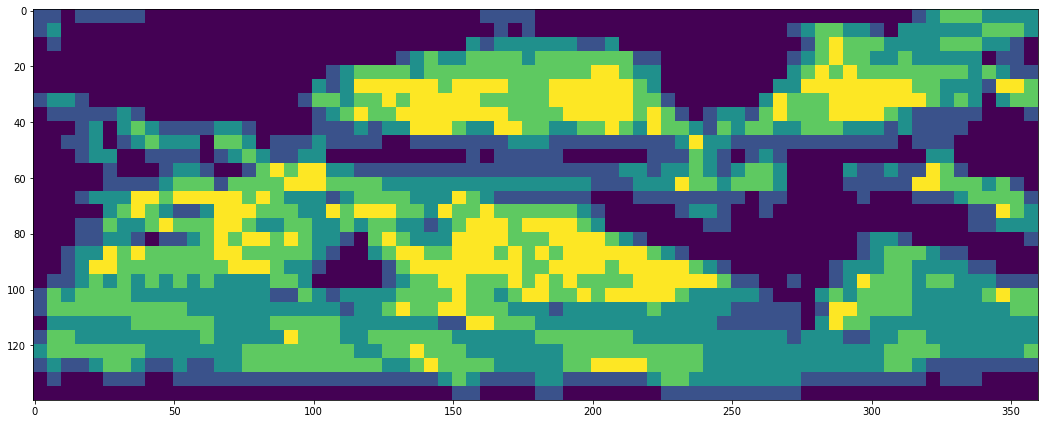

In [7]:
plt.figure(figsize=(18, 8))
plt.imshow(centrality_map.swapaxes(1, 0))
plt.show()